In [1]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from itertools import product
import random

In [7]:
df = pd.read_csv('../data/spotify_dataset.csv', usecols=range(4), lineterminator='\n', header=0)

In [8]:
df.columns = [x.replace('"', '').lstrip() for x in df.columns]

In [9]:
playlists = df['playlistname'].unique()
print('Number of Playlists:', len(playlists))
print('Number of Artists:', len(df['artistname'].unique()))

Number of Playlists: 161530
Number of Artists: 290002


#### Problem:
- Networkx takes too much time to load up a graph with all the data <br>
- In ~5 min we can retrieve 2000 artist genres


#### Potential Solution:
- Sample 1,000 playlists
- See if there is a sufficient amount of artists and playlist appearances

In [10]:
np.random.seed(0)
sample_playlists = np.random.choice(playlists, 1000, replace=False)
sampled_df = df[df['playlistname'].isin(sample_playlists)]

In [11]:
print('Number of songs in sample:', len(sampled_df))
print('Number of Artists:', len(sampled_df['artistname'].unique()))

Number of songs in sample: 66969
Number of Artists: 11292


In [12]:
appearances = sampled_df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
appearances.sort_values(by=['trackname', 'playlistname'])

,trackname,playlistname
artistname,,
!!!,1,1
047,1,1
10 Below,1,1
10 Years,1,1
12 Stones,1,1
...,...,...
Jethro Tull,324,5
Neil Young,371,4
Animal Collective,474,7


- There are some artists that appear on an insignificant amount of playlists, define this to be anything less than 10

In [13]:
artists = appearances[appearances['playlistname']>=10].index
print('# of artists on >= 10 playlists (sample):', len(artists))

# of artists on >= 10 playlists (sample): 199


In [14]:
df1 = sampled_df[sampled_df['artistname'].isin(artists)]
df1

,user_id,artistname,trackname,playlistname
1898,944c80d26922ae634d6ce445b1fdff7f,Kelly Clarkson,Because of You,JOOTDR
1903,944c80d26922ae634d6ce445b1fdff7f,Coldplay,Fix You,JOOTDR
1904,944c80d26922ae634d6ce445b1fdff7f,Passenger,Golden Thread (feat. Matt Corby),JOOTDR
1915,944c80d26922ae634d6ce445b1fdff7f,Oasis,Stop Crying Your Heart Out,JOOTDR
1918,944c80d26922ae634d6ce445b1fdff7f,Passenger,The One You love (feat. Kate Miller Heidke),JOOTDR
...,...,...,...,...
12847691,e6650a56a9c408231816d433da505557,Miley Cyrus,We Can't Stop,Trendy
12847693,e6650a56a9c408231816d433da505557,Lana Del Rey,West Coast,Trendy
12847694,e6650a56a9c408231816d433da505557,Two Door Cinema Club,What You Know,Trendy
12847695,e6650a56a9c408231816d433da505557,Lana Del Rey,Without You,Trendy


- Only take playlists that have more than 1 artist (otherwise there's no edge)

In [15]:
df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
playlists = df1_grped[df1_grped['artistname'] > 1].index

In [16]:
df2 = df1[df1['playlistname'].isin(playlists)]
df2

,user_id,artistname,trackname,playlistname
1898,944c80d26922ae634d6ce445b1fdff7f,Kelly Clarkson,Because of You,JOOTDR
1903,944c80d26922ae634d6ce445b1fdff7f,Coldplay,Fix You,JOOTDR
1904,944c80d26922ae634d6ce445b1fdff7f,Passenger,Golden Thread (feat. Matt Corby),JOOTDR
1915,944c80d26922ae634d6ce445b1fdff7f,Oasis,Stop Crying Your Heart Out,JOOTDR
1918,944c80d26922ae634d6ce445b1fdff7f,Passenger,The One You love (feat. Kate Miller Heidke),JOOTDR
...,...,...,...,...
12847691,e6650a56a9c408231816d433da505557,Miley Cyrus,We Can't Stop,Trendy
12847693,e6650a56a9c408231816d433da505557,Lana Del Rey,West Coast,Trendy
12847694,e6650a56a9c408231816d433da505557,Two Door Cinema Club,What You Know,Trendy
12847695,e6650a56a9c408231816d433da505557,Lana Del Rey,Without You,Trendy


In [17]:
# same def as quarter 1
def read_edge(gph, n0, n1):
    if gph.has_edge(n0, n1):
        gph[n0][n1]['weight'] +=1
    else:
        gph.add_edge(n0, n1, weight=1)

In [18]:
%%time
G = nx.Graph()
# if not unique, could weight the number of times the artist appears in that playlist
df2_grp = df2.groupby('playlistname').agg({'artistname': lambda x: (x).unique()})

for i in range(len(df2_grp)):
    
    for a in (df2_grp.iloc[i]):
        for a1, a2 in itertools.combinations(a, 2):
            read_edge(G, a1, a2)

CPU times: total: 62.5 ms
Wall time: 55 ms


CPU times: total: 109 ms
Wall time: 133 ms


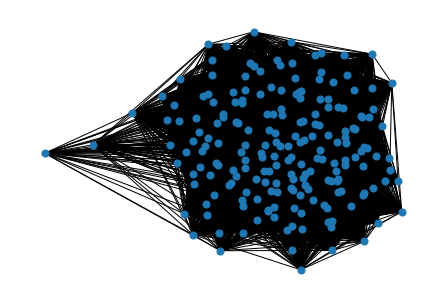

In [19]:
%%time
nx.draw(G, node_size=50)


In [20]:
G.size()

15851

In [21]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Vampire Weekend' in i:
        weight_dict[i] = node_weights[i]

In [22]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)

[(('Vampire Weekend', 'Kanye West'), 9),
 (('Daft Punk', 'Vampire Weekend'), 8),
 (('The Black Keys', 'Vampire Weekend'), 7),
 (('Vampire Weekend', 'JAY Z'), 7),
 (('Vampire Weekend', 'M.I.A.'), 7),
 (('Vampire Weekend', 'MGMT'), 7),
 (('Phoenix', 'Vampire Weekend'), 6),
 (('Vampire Weekend', 'Coldplay'), 6),
 (('Vampire Weekend', 'Franz Ferdinand'), 6),
 (('Vampire Weekend', 'The Killers'), 6),
 (('Maroon 5', 'Vampire Weekend'), 5),
 (('Beyoncé', 'Vampire Weekend'), 5),
 (('Rihanna', 'Vampire Weekend'), 5),
 (('Justin Timberlake', 'Vampire Weekend'), 5),
 (('Foster The People', 'Vampire Weekend'), 5),
 (('Miike Snow', 'Vampire Weekend'), 5),
 (('Vampire Weekend', 'The National'), 5),
 (('Vampire Weekend', 'Arcade Fire'), 5),
 (('Vampire Weekend', 'M83'), 5),
 (('Vampire Weekend', 'Britney Spears'), 5),
 (('Vampire Weekend', 'Fun.'), 5),
 (('Vampire Weekend', 'Arctic Monkeys'), 5),
 (('Vampire Weekend', 'Lady Gaga'), 5),
 (('Vampire Weekend', 'Two Door Cinema Club'), 5),
 (('Vampire We

In [23]:
threshold = 1
long_edges = list(filter(lambda e: e[2] <= threshold, (e for e in G.edges.data('weight'))))

In [24]:
G.remove_edges_from(long_edges)

In [25]:
A = nx.to_numpy_array(G)

In [26]:
def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad

def train(A, C, iterations = 100):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C)

    for n in range(iterations):
        for person in range(N):
            grad = gradient(F, A, person)

            F[person] += 0.005*grad

            F[person] = np.maximum(0.001, F[person]) # F should be nonnegative
        ll = log_likelihood(F, A)
    return F, log_likelihood(F, A)

In [27]:
#DO NOT NEED TO RUN AGAIN, JUST NEEDED TO GENERATE AUTH KEY 
auth_url = 'https://accounts.spotify.com/api/token'
data = {
   'grant_type': 'client_credentials',
   'client_id': "8ac5bd4f29854a4abb37648a5b7833d8",
   'client_secret': "c9f1281a0f774d97ae7d002139e53049",
}
auth_response = requests.post(auth_url, data=data)
access_token = auth_response.json().get('access_token')
access_token

'BQApp-58WNpjKHjKFmkc2uPBddzNGJI4UO_R0eUaSCG5hdtXcgpv9f6PWj5UXSpxLcxPw3G7gzY3gGu4356hxLjzT1izffGEcss_8YEuPrd1F1ODkifV'

In [28]:
ACCESS_TOKEN_LINE = "Bearer " + access_token
ACCESS_TOKEN_LINE

'Bearer BQApp-58WNpjKHjKFmkc2uPBddzNGJI4UO_R0eUaSCG5hdtXcgpv9f6PWj5UXSpxLcxPw3G7gzY3gGu4356hxLjzT1izffGEcss_8YEuPrd1F1ODkifV'

In [29]:
def get_spotify_genres(access, artist_names):
    # Set up the API endpoint and headers
    endpoint = "https://api.spotify.com/v1/search"
    headers = {
        "Authorization": access
    }

    # Create an empty list to store the genres
    artist_genres = {}

    # Iterate over the list of artists
    for artist_name in artist_names:
        # Specify the search parameters
        params = {
            "q": artist_name,
            "type": "artist"
        }

        # Send a GET request to the API endpoint
        response = requests.get(endpoint, headers=headers, params=params)

        # Parse the response as JSON
        data = json.loads(response.text)
        # Append the artist's genres to the list of genres
        result = data["artists"]["items"]
        if len(result) > 0:
            artist_genres[artist_name] = result[0]['genres']
    return artist_genres

In [30]:
artists = set()

In [31]:
for i in range(len(df2_grp)):
    art_list = df2_grp.iloc[i]['artistname']
    for j in art_list:
        artists.add(j.lower())

In [32]:
genres = get_spotify_genres(ACCESS_TOKEN_LINE, artists)

In [33]:
genres_list = []
for i in genres:
    genres_list += genres[i]

In [34]:
# collect count of each genre
genres_count = {val: genres_list.count(val) for val in set(genres_list)}

In [35]:
#perform bigclam algorithm
F, ll = train(A, 3)
pred = np.argmax(F, 1)

In [36]:
nodes = list(G.nodes())
one = [nodes[i] for i in np.where(pred == 0)[0]]
two = [nodes[i] for i in np.where(pred == 1)[0]]
three = [nodes[i] for i in np.where(pred == 2)[0]]

In [37]:
# if any of the artists have at least one shared genre within the 
# community it is considerd correct prediction
def correct_pred(pred, genres, nodes):
    total = 0
    for i in range(len(pred)):
        for j in range(len(pred)):
            if i != j:
                if len(set(genres[pred[i].lower()]).intersection(set(genres[pred[j].lower()]))) > 0:
                    total += 1
                    break
    return total

In [38]:
total = 0
for i in [one, two, three]:
    total += correct_pred(i, genres, nodes)

In [39]:
total/len(nodes)

0.9547738693467337

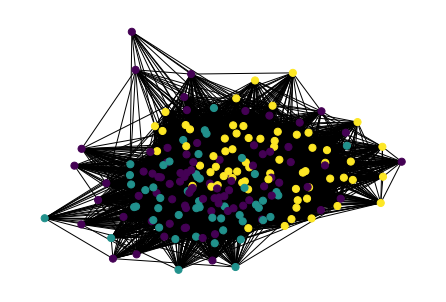

In [42]:
nx.draw(G, node_size=50, node_color = pred)